# Advanced Injector-Producer Connectivity Analysis (CRM)
**Author:** Ade Anggi Naluriawan Santoso | **Project:** Spatial Analysis and Connectivity

## Overview
This notebook implements an expert-level **Capacitance Resistance Model (CRM)** workflow. Unlike basic implementations, this workflow includes:

1.  **Object-Oriented Architecture:** A reusable Scikit-Learn style `CRMRegressor` class.
2.  **L2 Regularization (Ridge):** To handle collinearity and noise in injection data.
3.  **Rolling Window Analysis:** To detect dynamic changes in connectivity over time.
4.  **Geospatial Visualization:** Mapping connectivity flow on field coordinates.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from sklearn.base import BaseEstimator, RegressorMixin

# Style settings
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Load Production/Injection Data
df = pd.read_csv('production_injection_data_advance.csv', parse_dates=['Date'], index_col='Date')
inj_cols = [c for c in df.columns if c.startswith('I')]
prod_cols = [c for c in df.columns if c.startswith('P')]
X_inj = df[inj_cols].values

# Load Location Data (New!)
df_loc = pd.read_csv('well_locations.csv', index_col='Well')

print(f"Data Loaded: {len(df)} days")
print(f"Injectors: {len(inj_cols)} | Producers: {len(prod_cols)}")
df.head()

Data Loaded: 1000 days
Injectors: 10 | Producers: 40


,I01,I02,I03,I04,I05,I06,I07,I08,I09,I10,...,P31,P32,P33,P34,P35,P36,P37,P38,P39,P40
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,1026.114120,910.297795,1027.528233,403.729326,934.098434,1107.133771,1443.368213,844.518935,757.451919,849.472887,...,942.235657,542.684390,722.191181,924.711135,807.921947,646.164758,710.380104,853.347190,986.630372,946.569359
2020-01-02,1274.620635,1098.625333,841.071939,1153.980230,1029.123265,1290.593497,789.384072,901.701356,882.367554,560.945516,...,964.404435,558.036420,717.017935,940.341655,811.927444,663.973755,729.537894,868.004596,988.364047,941.158919
2020-01-03,1088.836083,1078.316582,1001.534037,929.623860,575.388777,873.806403,897.185645,759.316819,951.614287,1121.215257,...,967.395110,582.824590,720.091991,945.415446,819.576918,666.434967,746.976172,884.191233,996.183404,946.841608
2020-01-04,1565.855770,1052.373344,1077.265117,977.666225,424.368635,992.045837,1018.069063,1738.972634,942.291711,1090.464203,...,971.394142,612.404971,739.424612,955.177757,823.192546,668.513215,755.411303,890.188580,1002.324590,956.594256
2020-01-05,989.586469,649.396589,1342.846844,1225.579910,1237.309584,727.183764,1420.838293,579.444681,1176.057128,1657.136688,...,992.455050,640.654413,757.523235,962.931263,824.189317,690.452660,778.267965,892.411595,1011.122229,967.389862


## Part 1: The Expert CRM Class (OOP & Regularization)

We encapsulate the physics engine and optimization logic into a class named `CRMRegressor`. This allows us to treat the reservoir model just like a Machine Learning model (e.g., `model.fit()`, `model.predict()`).

**Key Enhancement: L2 Regularization**
We modify the objective function to include `lambda_reg * sum(weights^2)`. This prevents the model from assigning extreme positive/negative values to injectors that fluctuate together, ensuring physically realistic connectivity.

In [2]:
class CRMRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, tau_bounds=(1, 100), lambda_reg=0.1):
        """
        CRM Model for a single producer.
        
        Args:
            tau_bounds (tuple): Min and Max valid days for Tau.
            lambda_reg (float): L2 Regularization strength.
        """
        self.tau_bounds = tau_bounds
        self.lambda_reg = lambda_reg
        self.tau_ = None
        self.gains_ = None
        self.n_injectors = None
        
    def _simulate_physics(self, tau, gains, X_inj, q0):
        # Physics Engine (CRMP)
        n_steps, n_inj = X_inj.shape
        q_pred = np.zeros(n_steps)
        q_pred[0] = q0
        
        decay = np.exp(-1.0 / tau)
        inv_decay = 1.0 - decay
        weighted_I = np.dot(X_inj, gains)
        
        for t in range(1, n_steps):
            q_pred[t] = q_pred[t-1] * decay + weighted_I[t] * inv_decay
            
        return q_pred

    def fit(self, X_inj, y_prod):
        self.n_injectors = X_inj.shape[1]
        
        # Initial Guess: Tau=10, Gains=Equal split
        init_guess = np.concatenate(([10.0], np.ones(self.n_injectors)/self.n_injectors))
        
        # Bounds: Tau (user def), Gains (0 to 1)
        bounds = [self.tau_bounds] + [(0.0, 1.0) for _ in range(self.n_injectors)]
        
        # Objective Function with L2 Regularization
        def loss(params):
            tau, gains = params[0], params[1:]
            
            # Physics Penalty (Avoid Tau <= 0)
            if tau <= 0.01: return 1e9
            
            q_pred = self._simulate_physics(tau, gains, X_inj, y_prod[0])
            
            # SSE
            sse = np.sum((y_prod - q_pred)**2)
            
            # Regularization (Ridge)
            reg = self.lambda_reg * np.sum(gains**2)
            
            return sse + reg
            
        # Optimization
        res = minimize(loss, init_guess, bounds=bounds, method='L-BFGS-B')
        
        self.tau_ = res.x[0]
        self.gains_ = res.x[1:]
        return self

    def predict(self, X_inj, q0=None):
        if self.tau_ is None:
            raise ValueError("Model not trained yet.")
        if q0 is None:
            q0 = 0 # Default if not provided
        return self._simulate_physics(self.tau_, self.gains_, X_inj, q0)

## Part 2: Static Analysis (Field Wide)

We now loop through all 40 producers, fitting a `CRMRegressor` instance for each one.

In [3]:
results_data = []
models = {}

print("Training CRM models with Regularization...")

for p_name in prod_cols:
    y_data = df[p_name].values
    
    # Initialize and Fit Model
    model = CRMRegressor(tau_bounds=(5, 100), lambda_reg=0.5)
    model.fit(X_inj, y_data)
    
    # Store Model
    models[p_name] = model
    
    # Store Results for DataFrame
    row = {'Producer': p_name, 'Tau': model.tau_}
    for i, inj in enumerate(inj_cols):
        row[inj] = model.gains_[i]
    results_data.append(row)

df_results = pd.DataFrame(results_data).set_index('Producer')
print("Training Complete.")
df_results.head()

Training CRM models with Regularization...
Training Complete.


,Tau,I01,I02,I03,I04,I05,I06,I07,I08,I09,I10
Producer,,,,,,,,,,,
P01,19.037708,0.092163,0.000000,0.010139,0.025462,0.000000,0.000000,0.356262,0.302452,0.014250,0.294963
P02,26.923761,0.000000,0.012348,0.000000,0.025746,0.037621,0.000000,0.000000,0.110022,0.498326,0.158448
P03,13.047932,0.380528,0.000000,0.001712,0.022449,0.421600,0.000000,0.004654,0.056451,0.281052,0.000000
P04,31.125524,0.022942,0.000000,0.000000,0.000000,0.000000,0.056018,0.000000,0.295083,0.364668,0.279313
P05,27.199928,0.088540,0.000000,0.000000,0.000000,0.000000,0.000000,0.155590,0.269191,0.100630,0.346265


## Part 3: Dynamic Analysis (Rolling Window)

**Problem:** Reservoir connectivity is not static. Fractures can close, and sweep efficiency changes.
**Solution:** We run the CRM analysis on a **Rolling Window** (e.g., 1-year window, sliding every 3 months) to see how $f_{ij}$ changes over time.

Running Rolling Window Analysis for P01...


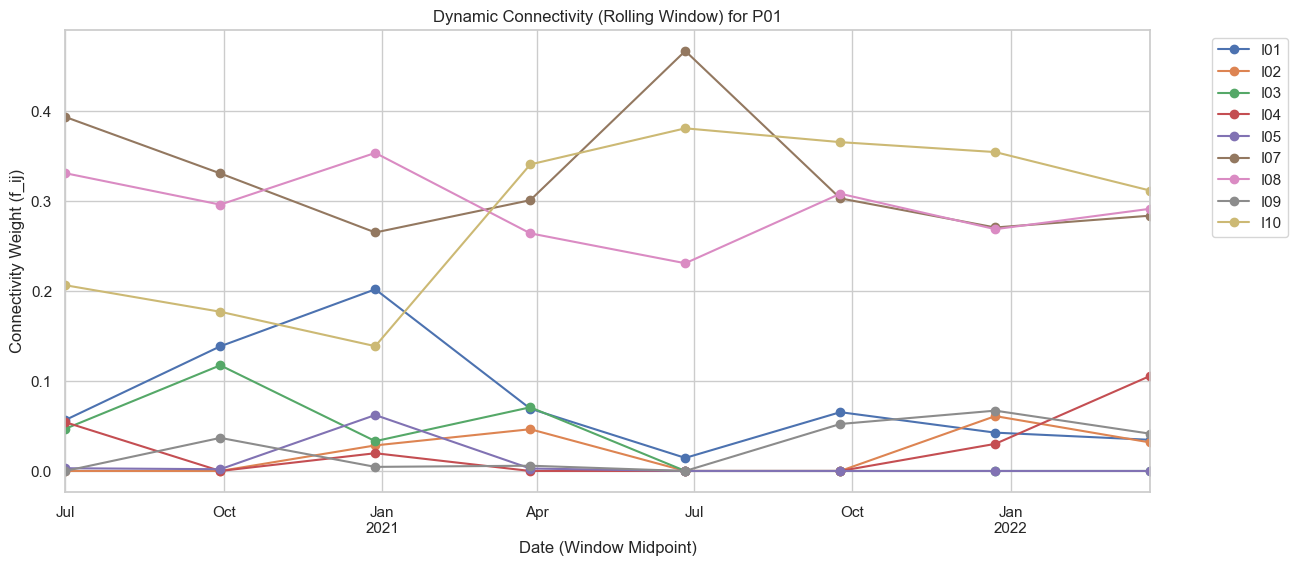

In [4]:
# Select one producer for deep dive
target_p = prod_cols[0] 
print(f"Running Rolling Window Analysis for {target_p}...")

window_size = 365 # 1 year data
step_size = 90    # Slide 3 months

rolling_dates = []
rolling_gains = []

for start in range(0, len(df) - window_size, step_size):
    end = start + window_size
    date_midpoint = df.index[start] + pd.Timedelta(days=window_size//2)
    
    # Slice Data
    X_sub = X_inj[start:end]
    y_sub = df[target_p].values[start:end]
    
    # Fit Model on Slice
    model = CRMRegressor(lambda_reg=0.5)
    model.fit(X_sub, y_sub)
    
    rolling_dates.append(date_midpoint)
    rolling_gains.append(model.gains_)

# Plotting Dynamic Connectivity
df_rolling = pd.DataFrame(rolling_gains, columns=inj_cols, index=rolling_dates)

plt.figure(figsize=(14, 6))
# Only plot injectors with significant contribution
active_injectors = df_rolling.columns[df_rolling.max() > 0.05]
df_rolling[active_injectors].plot(ax=plt.gca(), marker='o')

plt.title(f'Dynamic Connectivity (Rolling Window) for {target_p}')
plt.ylabel('Connectivity Weight (f_ij)')
plt.xlabel('Date (Window Midpoint)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Part 4: Geospatial Visualization



Finally, we map the static connectivity results onto the physical field coordinates. This helps identify directional trends and flow barriers.
* **Nodes:** Wells (Injectors = Blue, Producers = Red)
* **Edges:** Lines representing connectivity. Thicker lines = Stronger connection.

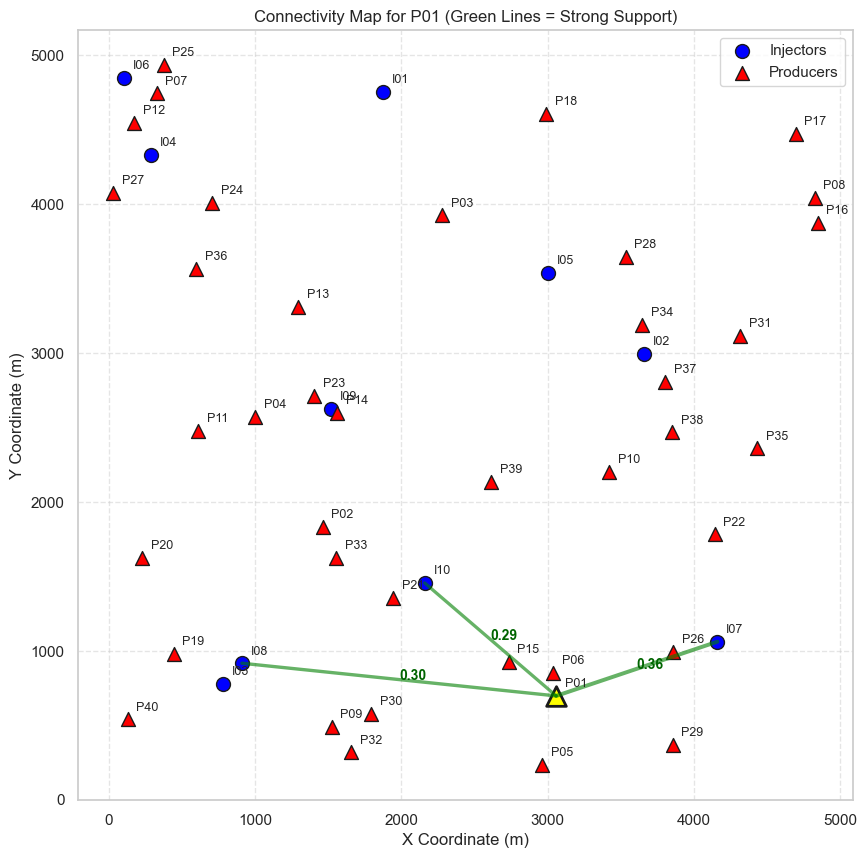

In [5]:
def plot_field_connectivity(target_producer):
    plt.figure(figsize=(10, 10))
    
    # 1. Plot Wells
    inj_locs = df_loc[df_loc['Type'] == 'Inj']
    prod_locs = df_loc[df_loc['Type'] == 'Prod']
    
    plt.scatter(inj_locs['X'], inj_locs['Y'], c='blue', s=100, label='Injectors', edgecolors='k')
    plt.scatter(prod_locs['X'], prod_locs['Y'], c='red', marker='^', s=100, label='Producers', edgecolors='k')
    
    # Highlight Target Producer
    target_loc = df_loc.loc[target_producer]
    plt.scatter(target_loc['X'], target_loc['Y'], c='yellow', marker='^', s=200, edgecolors='k', linewidth=2)
    
    # 2. Draw Connections
    # Get gains for this producer
    gains = df_results.loc[target_producer, inj_cols]
    
    for inj_name, weight in gains.items():
        if weight > 0.1: # Only draw strong connections
            inj_loc = df_loc.loc[inj_name]
            
            # Line width proportional to weight
            plt.plot([target_loc.X, inj_loc.X], [target_loc.Y, inj_loc.Y], 
                     c='green', alpha=0.6, linewidth=weight*8)
            
            # Annotate weight
            mid_x = (target_loc.X + inj_loc.X) / 2
            mid_y = (target_loc.Y + inj_loc.Y) / 2
            plt.text(mid_x, mid_y, f"{weight:.2f}", color='darkgreen', fontsize=10, fontweight='bold')

    # Label Wells
    for idx, row in df_loc.iterrows():
        plt.text(row.X + 60, row.Y + 60, idx, fontsize=9)
        
    plt.title(f'Connectivity Map for {target_producer} (Green Lines = Strong Support)')
    plt.xlabel('X Coordinate (m)')
    plt.ylabel('Y Coordinate (m)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# Visualize a specific producer
plot_field_connectivity(prod_cols[0])